<a href="https://colab.research.google.com/github/anjaliii210/Cross-Market-Meta-Learner/blob/main/meta_fin_fomaml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
class Model(nn.Module):

    def __init__(self, input_dim, num_classes=5):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU()
        )
        self.head = nn.Linear(16, num_classes)

    def forward(self, x):
        z = self.backbone(x)
        return self.head(z)


In [7]:
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "/content/drive/MyDrive/regime_project/saved_models"

def load_regime_models(input_dim, num_classes=5):
    regime_models = {}

    for fname in os.listdir(SAVE_DIR):
        if not fname.endswith(".pt"):
            continue

        ckpt = torch.load(os.path.join(SAVE_DIR, fname),map_location=DEVICE,weights_only=False)

        r = ckpt["regime"]

        model = Model(input_dim, num_classes).to(DEVICE)
        old_sd = ckpt["model_state"]
        model.load_state_dict(remap_state_dict(old_sd))


        regime_models[r] = model

    return regime_models

def remap_state_dict(old_sd):
    new_sd = {}
    new_sd["backbone.0.weight"] = old_sd["net.0.weight"]
    new_sd["backbone.0.bias"]   = old_sd["net.0.bias"]
    new_sd["head.weight"]       = old_sd["net.2.weight"]
    new_sd["head.bias"]         = old_sd["net.2.bias"]
    return new_sd


In [8]:
def freeze_backbone_adapt_head(model):
    for name, param in model.named_parameters():
        if "backbone" in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

In [9]:
import pandas as pd
import json
from google.colab import drive
drive.mount("/content/drive")

BASE_PATH = "/content/drive/MyDrive/regime_project"
with open(f"{BASE_PATH}/feature_cols_clean.json") as f:
    feature_cols_clean = json.load(f)

INPUT_DIM=len(feature_cols_clean)

Mounted at /content/drive


In [10]:
regime_models = load_regime_models(input_dim=INPUT_DIM,num_classes=3)

for r, model in regime_models.items():
    freeze_backbone_adapt_head(model)

In [11]:
for name, p in regime_models[0].named_parameters():
    print(name, p.requires_grad)

backbone.0.weight False
backbone.0.bias False
head.weight True
head.bias True


In [12]:
with open(f"{BASE_PATH}/regime_info.json") as f:
    regime_info = json.load(f)

In [37]:
import torch

def prepare_regime_tensors(df, feature_cols, target_col, regime_col):
    regime_data = {}

    for r in sorted(df[regime_col].unique()):
        df_r = df[df[regime_col] == r].sort_index()  # time-ordered

        X = torch.tensor(
            df_r[feature_cols].values,
            dtype=torch.float32
        )

        #fix for nans
        X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        y = torch.tensor(
            df_r[target_col].values,
            dtype=torch.long
        )

        regime_data[r] = (X, y)

    return regime_data

In [38]:
import pandas as pd

df = pd.read_parquet(
    f"{BASE_PATH}/df_assets_with_regimes.parquet"
)

In [39]:
regime_data = prepare_regime_tensors(
    df,
    feature_cols_clean,
    target_col="next_day_bucket_3cls",
    regime_col="regime_kmeans_3"
)

In [40]:
import random

def sample_episode(
    X,
    y,
    support_size,
    query_size
):
    T = len(X)
    assert T >= support_size + query_size

    start = random.randint(0, T - support_size - query_size)

    X_support = X[start : start + support_size]
    y_support = y[start : start + support_size]

    X_query = X[start + support_size : start + support_size + query_size]
    y_query = y[start + support_size : start + support_size + query_size]

    return X_support, y_support, X_query, y_query

In [41]:
def sample_task(
    regime_data,
    regime_id,
    support_size,
    query_size
):
    X, y = regime_data[regime_id]
    return sample_episode(X, y, support_size, query_size)

In [42]:
SUPPORT_SIZES = {
    0: 64,
    1: 16,   # intentionally small
    2: 64
}

QUERY_SIZES = {
    0: 64,
    1: 64,   #same
    2: 64
}
r = 1  # example

Xs, ys, Xq, yq = sample_task(
    regime_data,
    regime_id=r,
    support_size=SUPPORT_SIZES[r],
    query_size=QUERY_SIZES[r]
)

In [43]:
print(Xs.shape, Xq.shape)

torch.Size([16, 26]) torch.Size([64, 26])


FOMAML Implementation

In [44]:
import torch.nn.functional as F

REGIME_WEIGHTS = {
    0: 1.0,
    1: 2.5,   # upweight scarce regime
    2: 1.0
}

In [45]:
def inner_loop_adaptation(
    model,
    X_support,
    y_support,
    inner_lr=1e-3,
    inner_steps=1
):
    # clone model to avoid overwriting meta-init
    adapted_model = Model(INPUT_DIM, num_classes=3).to(X_support.device)
    adapted_model.load_state_dict(model.state_dict())

    # only head params
    params = [p for p in adapted_model.head.parameters() if p.requires_grad]

    for _ in range(inner_steps):
        logits = adapted_model(X_support)
        loss = F.cross_entropy(logits, y_support)

        grads = torch.autograd.grad(
            loss,
            params,
            create_graph=False   # FOMAML (no 2nd order)
        )

        #clamping grads
        grads = [g.clamp(-5.0, 5.0) for g in grads]

        # manual SGD step
        with torch.no_grad():
            for p, g in zip(params, grads):
                p -= inner_lr * g

    return adapted_model

In [46]:
#one meta episode
def run_episode(
    model,
    Xs, ys,
    Xq, yq,
    inner_lr,
    inner_steps
):
    adapted_model = inner_loop_adaptation(
        model, Xs, ys, inner_lr, inner_steps
    )

    logits_q = adapted_model(Xq)
    loss_q = F.cross_entropy(logits_q, yq)

    return loss_q

Outer Loop Adaptation

In [47]:
meta_optimizer = torch.optim.Adam(
    [p for r in regime_models for p in regime_models[r].parameters() if p.requires_grad],
    lr=1e-3
)

In [48]:
X, y = regime_data[0]
print(torch.isnan(X).any(), torch.isinf(X).any())
print(torch.unique(y))        #checking for nan values

tensor(False) tensor(False)
tensor([0, 1, 2])


In [49]:
def meta_step(
    regime_models,
    regime_data,
    inner_lr=1e-2,
    inner_steps=1
):
    meta_optimizer.zero_grad()

    meta_loss = 0.0
    weight_sum = 0.0

    for r, model in regime_models.items():
        X, y = regime_data[r]

        Xs, ys, Xq, yq = sample_episode(
            X, y,
            SUPPORT_SIZES[r],
            QUERY_SIZES[r]
        )

        loss_q = run_episode(
            model,
            Xs, ys,
            Xq, yq,
            inner_lr,
            inner_steps
        )

        w = REGIME_WEIGHTS[r]
        meta_loss += w * loss_q
        weight_sum += w

    meta_loss = meta_loss / weight_sum
    meta_loss.backward()
    meta_optimizer.step()

    return meta_loss.item()

In [50]:
for step in range(200):
    loss = meta_step(
        regime_models,
        regime_data,
        inner_lr=1e-2,
        inner_steps=1
    )

    if step % 20 == 0:
        print(f"[Meta step {step}] loss: {loss:.4f}")

[Meta step 0] loss: 0.7837
[Meta step 20] loss: 0.6727
[Meta step 40] loss: 0.6397
[Meta step 60] loss: 0.8004
[Meta step 80] loss: 0.8032
[Meta step 100] loss: 0.7648
[Meta step 120] loss: 0.7988
[Meta step 140] loss: 0.5990
[Meta step 160] loss: 0.6045
[Meta step 180] loss: 0.9090


In [51]:
for name, p in regime_models[0].named_parameters():
    if "backbone" in name:
        print(name, p.grad)

backbone.0.weight None
backbone.0.bias None


## Evaluation

episode evaluation

In [52]:
def evaluate_episode(
    model,
    Xs, ys,
    Xq, yq,
    inner_lr=1e-2,
    inner_steps=1
):
    # pre-adaptation loss-no grad
    with torch.no_grad():
        loss_pre = F.cross_entropy(model(Xq), yq)

    # adaptation needs gradients
    adapted_model = inner_loop_adaptation(
        model, Xs, ys, inner_lr, inner_steps
    )

    # post-adaptation loss-no grad
    with torch.no_grad():
        loss_post = F.cross_entropy(adapted_model(Xq), yq)

    gain = loss_pre - loss_post
    return loss_pre.item(), loss_post.item(), gain.item()

regime wise evaluation

In [53]:
import numpy as np

def evaluate_regime(
    model,
    regime_id,
    regime_data,
    n_episodes=50,
    inner_lr=1e-2,
    inner_steps=1
):
    X, y = regime_data[regime_id]

    results = []

    for _ in range(n_episodes):
        Xs, ys, Xq, yq = sample_episode(
            X, y,
            SUPPORT_SIZES[regime_id],
            QUERY_SIZES[regime_id]
        )

        device = next(model.parameters()).device
        Xs, ys = Xs.to(device), ys.to(device)
        Xq, yq = Xq.to(device), yq.to(device)


        lp, lq, gain = evaluate_episode(
            model, Xs, ys, Xq, yq,
            inner_lr, inner_steps
        )

        results.append((lp, lq, gain))

    results = np.array(results)
    return {
        "loss_pre_mean": results[:,0].mean(),
        "loss_post_mean": results[:,1].mean(),
        "gain_mean": results[:,2].mean(),
        "gain_std": results[:,2].std()
    }

evaluation over all regimes

In [54]:
for r, model in regime_models.items():
    stats = evaluate_regime(
        model,
        regime_id=r,
        regime_data=regime_data,
        n_episodes=50,
        inner_lr=1e-2,
        inner_steps=1
    )

    print(f"\nRegime {r}")
    for k, v in stats.items():
        print(f"{k}: {v:.4f}")


Regime 0
loss_pre_mean: 1.1252
loss_post_mean: 0.9749
gain_mean: 0.1503
gain_std: 0.2947

Regime 1
loss_pre_mean: 1.0418
loss_post_mean: 0.6086
gain_mean: 0.4332
gain_std: 0.1250

Regime 2
loss_pre_mean: 1.1962
loss_post_mean: 0.8182
gain_mean: 0.3780
gain_std: 0.1047


### Comparison with baselines

1.comparison with no adaptation

In [55]:
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def evaluate_frozen_baseline(
    model,
    regime_id,
    regime_data,
    n_episodes=50
):
    X, y = regime_data[regime_id]
    losses = []

    for _ in range(n_episodes):
        _, _, Xq, yq = sample_episode(
            X, y,
            SUPPORT_SIZES[regime_id],
            QUERY_SIZES[regime_id]
        )

        device = next(model.parameters()).device
        Xq, yq = Xq.to(device), yq.to(device)

        loss = F.cross_entropy(model(Xq), yq)
        losses.append(loss.item())

    return np.mean(losses), np.std(losses)

In [56]:
for r, model in regime_models.items():
    mean_loss, std_loss = evaluate_frozen_baseline(
        model, r, regime_data
    )
    print(f"Regime {r} | Frozen loss: {mean_loss:.4f} ± {std_loss:.4f}")

Regime 0 | Frozen loss: 1.1295 ± 0.0411
Regime 1 | Frozen loss: 1.0314 ± 0.0385
Regime 2 | Frozen loss: 1.1868 ± 0.0543


2.checking if FOMAML beats naive few shot fine training

In [65]:
def head_only_retrain(
    model,
    Xs, ys,
    lr=1e-2,
    steps=20
):
    temp_model = Model(INPUT_DIM, num_classes=3).to(Xs.device)
    temp_model.load_state_dict(model.state_dict())

    for p in temp_model.backbone.parameters():
        p.requires_grad = False

    opt = torch.optim.SGD(temp_model.head.parameters(), lr=lr)

    for _ in range(steps):
        opt.zero_grad()
        loss = F.cross_entropy(temp_model(Xs), ys)
        loss.backward()
        opt.step()

    return temp_model

In [66]:
def evaluate_head_only_baseline(
    model,
    regime_id,
    regime_data,
    n_episodes=50
):
    X, y = regime_data[regime_id]
    gains = []

    for _ in range(n_episodes):
        Xs, ys, Xq, yq = sample_episode(
            X, y,
            SUPPORT_SIZES[regime_id],
            QUERY_SIZES[regime_id]
        )

        device = next(model.parameters()).device
        Xs, ys = Xs.to(device), ys.to(device)
        Xq, yq = Xq.to(device), yq.to(device)

        pre = F.cross_entropy(model(Xq), yq)

        adapted = head_only_retrain(model, Xs, ys)
        with torch.no_grad():
          post = F.cross_entropy(adapted(Xq), yq)

        gains.append((pre - post).item())

    return np.mean(gains), np.std(gains)

In [67]:
print("\nHead-only retraining baseline")
for r, model in regime_models.items():
    gain_mean, gain_std = evaluate_head_only_baseline(
        model=model,
        regime_id=r,
        regime_data=regime_data,
        n_episodes=50
    )
    print(f"Regime {r} | gain: {gain_mean:.4f} ± {gain_std:.4f}")


Head-only retraining baseline
Regime 0 | gain: 0.2682 ± 0.1743
Regime 1 | gain: 0.5207 ± 0.1437
Regime 2 | gain: 0.4696 ± 0.1626


Adaptation gain vs Support size

In [60]:
import matplotlib.pyplot as plt

def gain_vs_support_plot(
    model,
    regime_id,
    regime_data,
    support_sizes,
    n_episodes=30
):
    gains = []

    for s in support_sizes:
        SUPPORT_SIZES[regime_id] = s
        stats = evaluate_regime(
            model,
            regime_id,
            regime_data,
            n_episodes=n_episodes
        )
        gains.append(stats["gain_mean"])

    plt.plot(support_sizes, gains, marker="o")
    plt.xlabel("Support Size")
    plt.ylabel("Adaptation Gain")
    plt.title(f"Regime {regime_id}: Gain vs Support Size")
    plt.grid(True)
    plt.show()

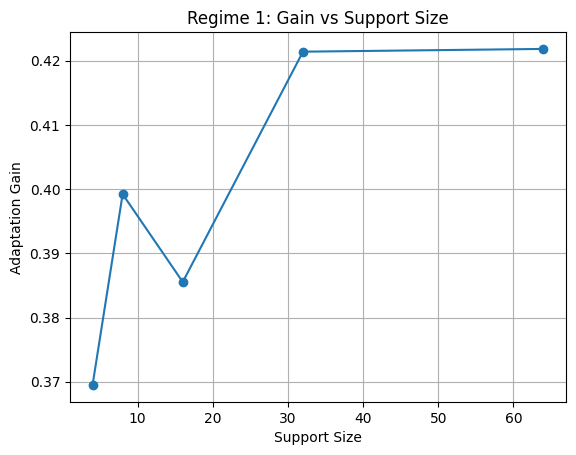

In [61]:
gain_vs_support_plot(
    regime_models[1],
    regime_id=1,
    regime_data=regime_data,
    support_sizes=[4, 8, 16, 32, 64]
)

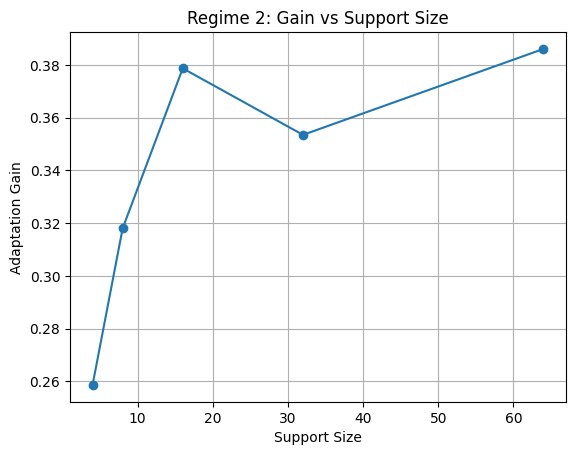

In [63]:
gain_vs_support_plot(
    model=regime_models[2],
    regime_id=2,
    regime_data=regime_data,
    support_sizes=[4, 8, 16, 32, 64],
    n_episodes=30
)

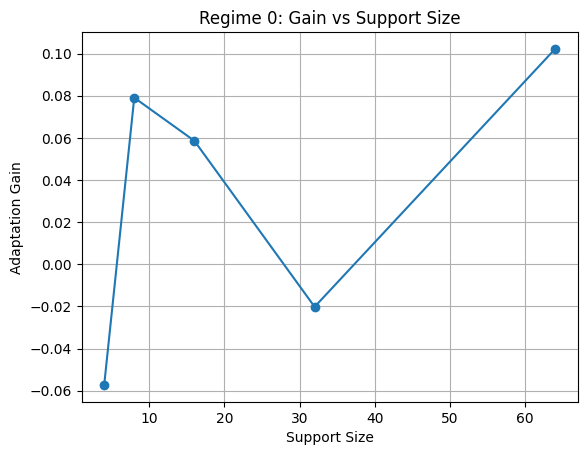

In [64]:
gain_vs_support_plot(
    model=regime_models[0],
    regime_id=0,
    regime_data=regime_data,
    support_sizes=[4, 8, 16, 32, 64],
    n_episodes=30
)